<a href="https://colab.research.google.com/github/rnoxy/dl_uwr/blob/summer2024/Assignments/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

import random
import gc

## Assignment 2

**Submission deadlines:**
- get at least 4 points by 12.03.2024 (Tue groups)
- get at least next 4 points by 19.03.2024 (Tue groups)
- remaining points: by 26.03.2024 (Tue groups)

**Points:** Aim to get 16 out of 18+ possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`
![Picture title](image-20220302-183151.png)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

## Extra points

You can earn extra 2 points if all your experiments are logged with [Weights and Biases](http://wandb.ai)


# Problems


## Problem 1 [1p]:

Let's see why GPUs are useful in deep learning. Compare matrix multiplication speed for a few matrix shapes when implemented:
1. as loops in Python
2. using np.einsum
3. using numpy on CPU
4. using pytorch on CPU
5. using pytorch on GPU

Finally, consider two square matrices, $A$ and $B$. We have 4 possibilities of multiplying them or their transpositions:
1. $AB$
2. $A^TB$
3. $AB^T$
4. $A^TB^T$

Which option is the fastest? Why?

In [ ]:
import numpy as np
import torch
import timeit

def matmul_python(A, B):
    C = [[0 for _ in range(len(B[0]))] for _ in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                C[i][j] += A[i][k] * B[k][j]
    return C

def time_matmul_python(A, B):
    setup = "from __main__ import matmul_python, A, B"
    return timeit.timeit("matmul_python(A, B)", setup=setup, number=1)

def time_matmul_einsum(A, B):
    setup = "import numpy as np; from __main__ import A, B"
    return timeit.timeit("np.einsum('ij,jk->ik', A, B)", setup=setup, number=1)

def time_matmul_numpy(A, B):
    setup = "import numpy as np; from __main__ import A, B"
    return timeit.timeit("np.dot(A, B)", setup=setup, number=1)

def time_matmul_pytorch_cpu(A, B):
    setup = "import torch; from __main__ import torch, A, B"
    return timeit.timeit("torch.matmul(torch.tensor(A), torch.tensor(B))", setup=setup, number=1)

def time_matmul_pytorch_gpu(A, B):
    setup = "import torch; from __main__ import torch, A, B"
    if torch.cuda.is_available():
      return timeit.timeit("torch.matmul(torch.tensor(A).cuda(), torch.tensor(B).cuda())", setup=setup, number=1)
    else:
      return torch.inf


shapes = [(500, 500)]

for shape in shapes:
    A = np.random.rand(*shape)
    B = np.random.rand(*shape)

    print(f"\nMatrix shape: {shape}")

    print("\nAB")
    print("Loop-based Python:", time_matmul_python(A, B))
    print("np.einsum:", time_matmul_einsum(A, B))
    print("Numpy on CPU:", time_matmul_numpy(A, B))
    print("PyTorch on CPU:", time_matmul_pytorch_cpu(torch.tensor(A), torch.tensor(B)))
    print("PyTorch on GPU:", time_matmul_pytorch_gpu(torch.tensor(A), torch.tensor(B)))

    print("\nA^T B")
    print("Loop-based Python:", time_matmul_python(A.T, B))
    print("np.einsum:", time_matmul_einsum(A.T, B))
    print("Numpy on CPU:", time_matmul_numpy(A, B))
    print("PyTorch on CPU:", time_matmul_pytorch_cpu(torch.tensor(A.T), torch.tensor(B)))
    print("PyTorch on GPU:", time_matmul_pytorch_gpu(torch.tensor(A.T), torch.tensor(B)))

    print("\nA B^T")
    print("Loop-based Python:", time_matmul_python(A, B.T))
    print("np.einsum:", time_matmul_einsum(A, B.T))
    print("Numpy on CPU:", time_matmul_numpy(A, B.T))
    print("PyTorch on CPU:", time_matmul_pytorch_cpu(torch.tensor(A), torch.tensor(B.T)))
    print("PyTorch on GPU:", time_matmul_pytorch_gpu(torch.tensor(A), torch.tensor(B.T)))

    print("\nA^T B^T")
    print("Loop-based Python:", time_matmul_python(A.T, B.T))
    print("np.einsum:", time_matmul_einsum(A.T, B.T))
    print("Numpy on CPU:", time_matmul_numpy(A.T, B.T))
    print("PyTorch on CPU:", time_matmul_pytorch_cpu(torch.tensor(A.T), torch.tensor(B.T)))
    print("PyTorch on GPU:", time_matmul_pytorch_gpu(torch.tensor(A.T), torch.tensor(B.T)))


Matrix shape: (500, 500)

AB
Loop-based Python: 101.33799226300016
np.einsum: 0.05326660800028549
Numpy on CPU: 0.009401048000199808
PyTorch on CPU: 0.017806566000217572
PyTorch on GPU: inf

A^T B
Loop-based Python: 99.91380093600037
np.einsum: 0.0533171410002069
Numpy on CPU: 0.008625682000001689
PyTorch on CPU: 0.017386143000294396
PyTorch on GPU: inf

A B^T
Loop-based Python: 102.23362787799988
np.einsum: 0.06362629300019762
Numpy on CPU: 0.017053655999916373
PyTorch on CPU: 0.01506901300035679
PyTorch on GPU: inf

A^T B^T
Loop-based Python: 100.60278969000001
np.einsum: 0.05449017499995534
Numpy on CPU: 0.008406593000017892
PyTorch on CPU: 0.012796537000212993
PyTorch on GPU: inf


## Problem 2: Stochastic Gradient Descent (training MNIST digits) [3p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

## Problem 3: Tuning the Network for MNIST [3p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    a good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

## Problem 4: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

## Problem 10: Pruning [1p]

Prune the MNIST network to retain validation accuracy no worse than 0.1 percentage point at maximum sparsity (maximal number of weights removed from the network).

One way to do it is to
1. train the network,
2. set to zero the smallest weights (typically you can zero up to 50% of weights)
3. retrain the network, keeping the zeroed weights zeroed, and repeat

## Problem 11: Other tricks [1p-many]

The neural network literature is full of tricks for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand

# Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [2]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [3]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
        transform=None,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        self.transform = transform

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            if self.transform:
              samples = self.dataset[batch_indices][0]
              labels = self.dataset[batch_indices][1]
              transformed_samples = self.transform(samples)
              yield transformed_samples, labels
            else:
              yield self.dataset[batch_indices]


    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [4]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

transform2 = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomCrop(size=(28, 28), pad_if_needed=True),
    torchvision.transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),
])

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True, transform=transform2),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False, transform=transform2),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

# mnist_loaders = {
#     "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
#     "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
#     "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
# }

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 8565985.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 8666167.82it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 7491614.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 5399809.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_30970/3806184100.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
for x, y in mnist_loaders["train"]:
    print(x)
    print(y)
    print(x.shape)
    print(y.shape)
    break

tensor([[[[ 1.2172e-01,  4.6886e-02,  9.3290e-02,  ..., -5.0888e-01,
            2.9460e-02,  1.4509e-01],
          [ 1.9651e-01, -5.2875e-02, -4.0910e-01,  ..., -6.0309e-01,
            6.4946e-02, -1.0156e-01],
          [-3.8613e-01, -4.4800e-01, -3.4647e-01,  ..., -4.4742e-01,
           -4.9869e-01,  2.3397e-02],
          ...,
          [ 1.6016e-01, -4.4485e-01, -3.0051e-01,  ..., -5.1122e-01,
           -5.4835e-01, -5.6070e-01],
          [-1.9274e-04, -2.3742e-04, -4.5031e-01,  ..., -3.0124e-01,
           -7.8129e-03,  6.7636e-02],
          [ 9.0353e-02,  7.7358e-02, -2.9020e-01,  ..., -5.5009e-02,
            6.3637e-02, -8.7337e-02]]],


        [[[ 6.6690e-02, -1.4227e-01, -2.4947e-01,  ..., -4.7847e-01,
            2.9284e-02,  1.2739e-01],
          [ 2.5054e-02, -1.9023e-01, -5.0323e-01,  ..., -4.6540e-01,
            2.5220e-02, -6.8804e-02],
          [-2.5376e-01, -3.5203e-01, -4.6686e-01,  ..., -3.6136e-01,
           -3.2630e-01,  6.7876e-02],
          ...,
   

## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

In [5]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.1,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]

    dropout = False
    try:
        if model.dropout_ppb: dropout = True
    except:
        pass
        
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        initial_alpha = alpha
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            alpha = initial_alpha / (epoch)

            # dropout
            if dropout and model.dropout_ppb != 0:
                model.dropout_init(device)
                

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)

                if isinstance(out, tuple):
                  out = out[0]

                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)

                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            p.grad += 2 * p * decay

                        v_prev = v[...]
                        if dropout and "conv" in name:
                            v[...] = epsilon * v[...] - alpha * p.grad * model.dropout_masks[name]
                            p += (-epsilon * v_prev + (1+epsilon) * v[...]) * model.dropout_masks[name]
                        else:
                            v[...] = epsilon * v[...] - alpha * p.grad
                            p += (-epsilon * v_prev + (1+epsilon) * v[...])

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

            # koniec epoki wiec przywracac wagi
            if dropout and model.dropout_ppb != 0:
                model.dropout_next_epoch()
                

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

## Problem 2

----------------------------------------------------------
After epoch  8 | valid err rate: 14.71% | doing   8 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 5)

-------------------------------------------
Test error rate: 15.000%, training took 5s.
-------------------------------------------


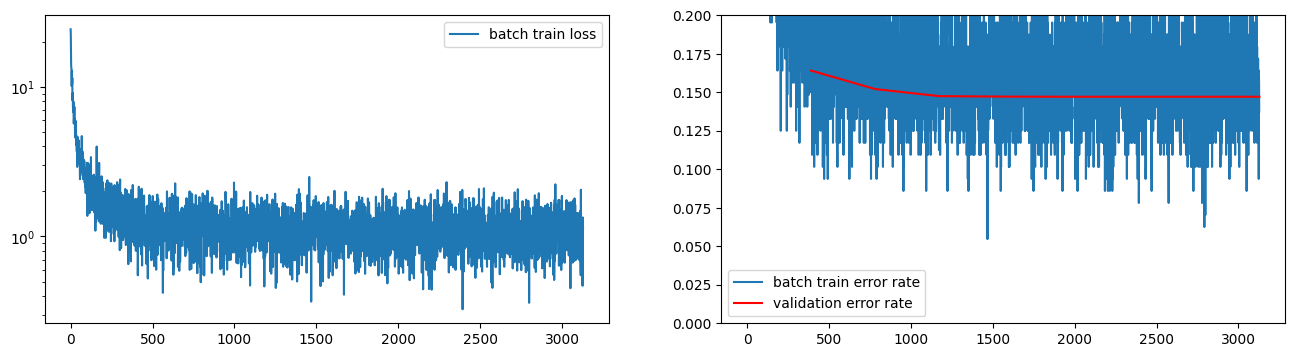

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(nn.Linear(28 * 28, 10))

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, max_num_epochs=30, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

## auxiliary

In [6]:
def show_filters(cnn_model):
    # Get the dataloader for validation data
    valid_loader = mnist_loaders["test"]
    
    # Get the first batch from the validation data
    batch_iterator = iter(valid_loader)
    sample_images, _ = next(batch_iterator)
    
    # Wybierz ósmą cyfrę ze zbioru danych (indeks 7, ponieważ indeksowanie zaczyna się od 0)
    sample_image = sample_images[random.randint(0, batch_size - 1)]
    
    # Pass the sample image through the model
    cnn_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Pass the sample image through the model
        conv1_output = cnn_model.conv1(sample_image.unsqueeze(0))
        maxpool1_output = cnn_model.maxpool1(conv1_output)
        conv2_output = cnn_model.conv2(maxpool1_output)
        maxpool2_output = cnn_model.maxpool2(conv2_output)
    
    # Plot the original image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot the outputs after each layer
    outputs = [conv1_output, maxpool1_output, conv2_output, maxpool2_output]
    layer_names = ['Conv1', 'MaxPool1', 'Conv2', 'MaxPool2']
    
    for i in range(4):
        output_image = outputs[i][0, 0].detach().cpu().numpy()
        plt.subplot(1, 5, i + 2)
        plt.imshow(output_image, cmap='gray')
        plt.title(layer_names[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## Problem 3

----------------------------------------------------------
After epoch 30 | valid err rate:  1.98% | doing  44 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 29)

---------------------------------------------
Test error rate: 1.890%, training took 2354s.
---------------------------------------------


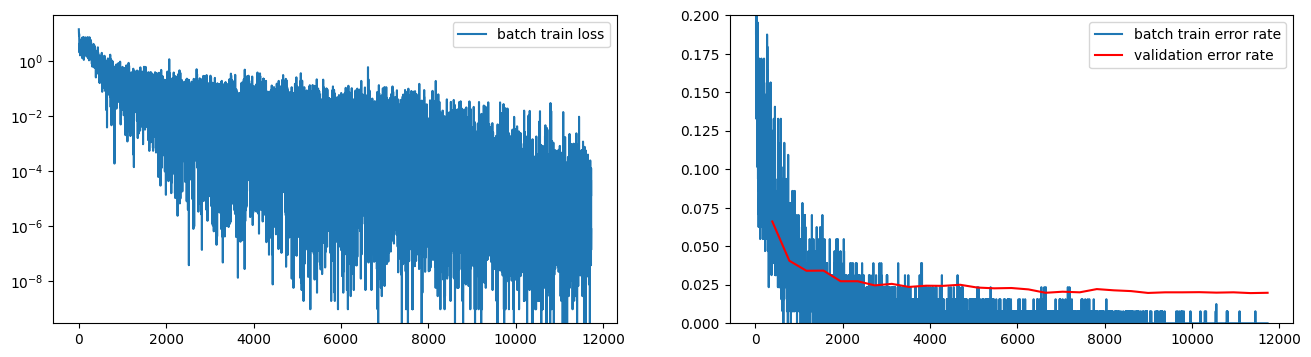

In [ ]:
model = Model(nn.Linear(28 * 28, 4999), nn.ReLU(), nn.Linear(4999,10))

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.08)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.001, max_num_epochs=30, device="cpu", decay=0.00001, epsilon=0.999)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


## Problem 4

----------------------------------------------------------
After epoch 30 | valid err rate:  1.06% | doing  35 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 23)

--------------------------------------------
Test error rate: 0.880%, training took 203s.
--------------------------------------------


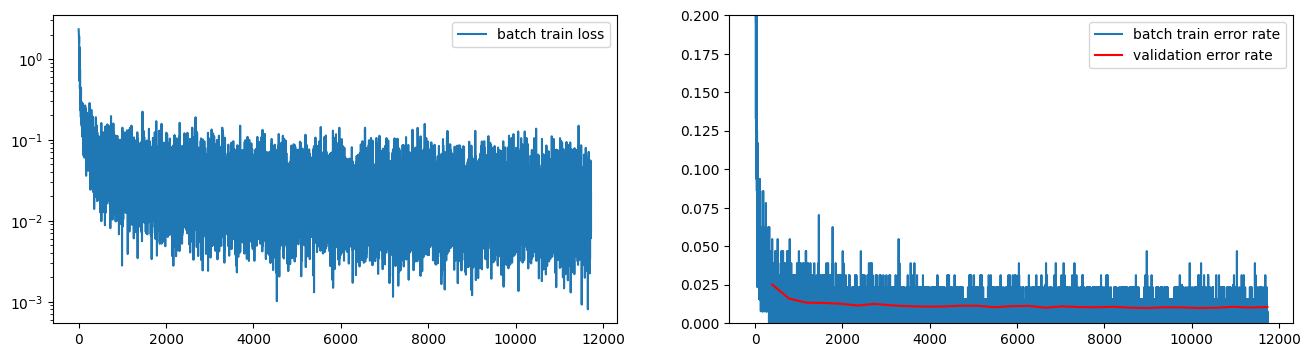

In [6]:
import torch.nn.init as init

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = ConvModel()

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Conv2d) or isinstance(p, nn.Linear):
          n = p.weight.size(1)  # Number of input channels or neurons
          std = torch.sqrt(torch.tensor(1.0 / n))
          nn.init.normal_(p.weight, mean=0, std=std)
          if p.bias is not None:
              nn.init.zeros_(p.bias)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=15, max_num_epochs=30, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

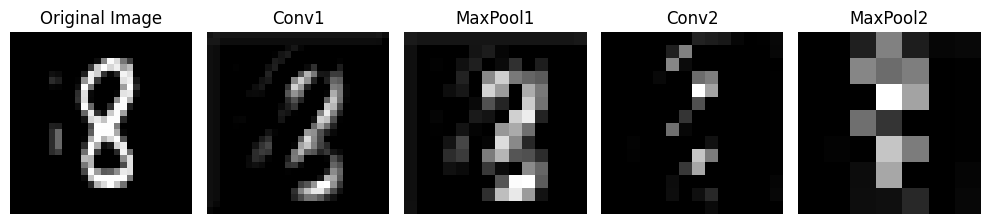

In [9]:
show_filters(model)

## Problem 5

----------------------------------------------------------
After epoch 22 | valid err rate:  1.50% | doing  22 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 14)

--------------------------------------------
Test error rate: 0.780%, training took 175s.
--------------------------------------------


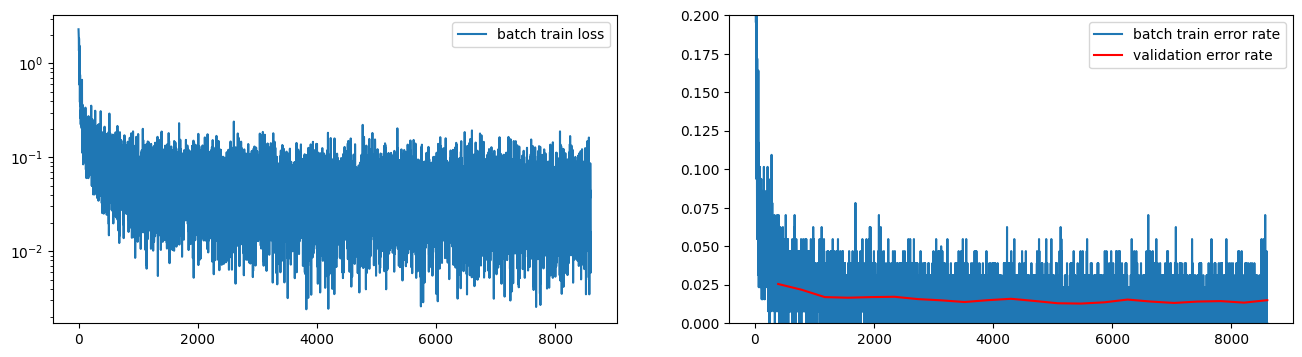

In [16]:
import torch.nn.init as init

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = ConvModel()

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Conv2d) or isinstance(p, nn.Linear):
          n = p.weight.size(1)
          std = torch.sqrt(torch.tensor(1.0 / n))
          nn.init.normal_(p.weight, mean=0, std=std)
          if p.bias is not None:
              nn.init.zeros_(p.bias)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=15, max_num_epochs=30, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

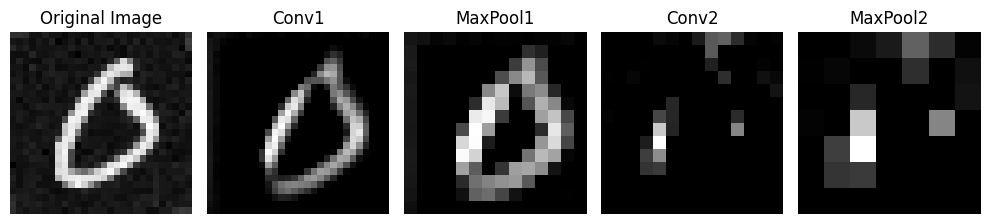

In [17]:
show_filters(model)

## Problem 6

----------------------------------------------------------
After epoch 49 | valid err rate:  1.98% | doing  49 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 32)

--------------------------------------------
Test error rate: 1.470%, training took 423s.
--------------------------------------------


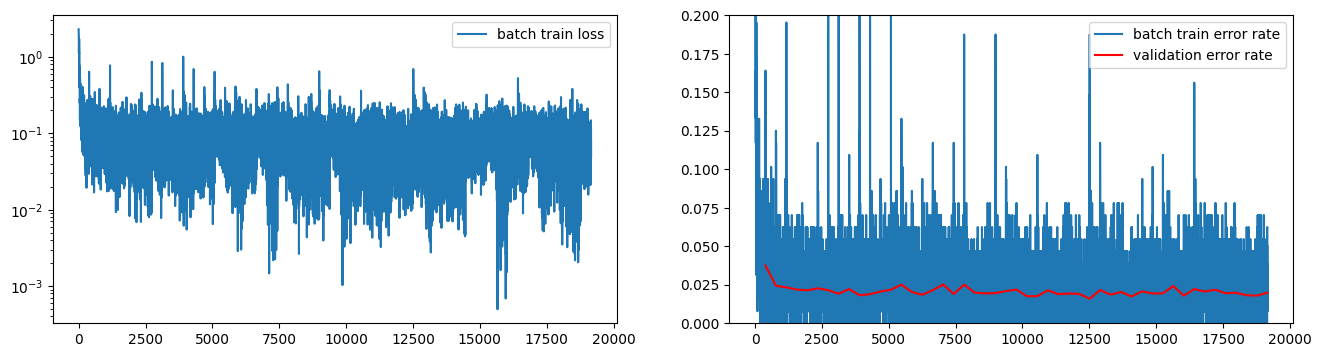

In [39]:
import torch.nn.init as init

class ConvModel(nn.Module):
    def __init__(self, dropout_ppb=0):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(32 * 7 * 7, 10)

        self.dropout_ppb = dropout_ppb
        self.dropout_masks = None
        # trzeba wyzorwac filtry i pozniej przyworic, zeby nie braly udzialu rowniez w forward
        self.conv1_w_save = None
        self.conv2_w_save = None
        self.conv1_b_save = None
        self.conv2_b_save = None

    # dropout na pixelach w filtrach zamiast an calych
    def dropout_init(self, device):
        conv1_dropout = torch.rand(16) < self.dropout_ppb
        conv2_dropout = torch.rand(32) < self.dropout_ppb

        # self.conv1_w_save = self.conv1[0].weight.detach().clone()[~conv1_dropout, :, :, :] = 0
        # self.conv2_w_save = self.conv2[0].weight.detach().clone()[~conv2_dropout, :, :, :] = 0
        # self.conv1_b_save = self.conv1[0].bias.detach().clone()[~conv1_dropout] = 0
        # self.conv2_b_save = self.conv2[0].bias.detach().clone()[~conv2_dropout] = 0

        self.conv1_w_save = self.conv1[0].weight.detach().clone()
        self.conv2_w_save = self.conv2[0].weight.detach().clone()
        self.conv1_b_save = self.conv1[0].bias.detach().clone()
        self.conv2_b_save = self.conv2[0].bias.detach().clone()
    
        self.conv1_w_save[~conv1_dropout, :, :, :] = 0
        self.conv2_w_save[~conv2_dropout, :, :, :] = 0
        self.conv1_b_save[~conv1_dropout] = 0
        self.conv2_b_save[~conv2_dropout] = 0
        
        self.dropout_masks = {
            "conv1.0.weight": torch.ones((16, 1, 5, 5), device=device),
            "conv1.0.bias": torch.ones((16), device=device),
            "conv2.0.weight": torch.ones((32, 16, 5, 5), device=device),
            "conv2.0.bias": torch.ones((32), device=device),
        }

        self.dropout_masks["conv1.0.weight"][conv1_dropout, :, :, :] = 0
        self.dropout_masks["conv1.0.bias"][conv1_dropout] = 0
        self.dropout_masks["conv2.0.weight"][conv2_dropout, :, :, :] = 0
        self.dropout_masks["conv2.0.bias"][conv2_dropout] = 0
        
        with torch.no_grad():
            self.conv1[0].weight *= self.dropout_masks["conv1.0.weight"]
            self.conv1[0].bias *= self.dropout_masks["conv1.0.bias"]
            self.conv2[0].weight *= self.dropout_masks["conv2.0.weight"]
            self.conv2[0].bias *= self.dropout_masks["conv2.0.bias"]
            
            
    def dropout_next_epoch(self):
        with torch.no_grad():
            self.conv1[0].weight += self.conv1_w_save
            self.conv1[0].bias += self.conv1_b_save
            self.conv2[0].weight += self.conv2_w_save
            self.conv2[0].bias += self.conv2_b_save

            self.conv1_w_save = None
            self.conv2_w_save = None
            self.conv1_b_save = None
            self.conv2_b_save = None

            self.dropout_masks = None

            gc.collect()


    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = ConvModel(dropout_ppb=0.3)

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Conv2d) or isinstance(p, nn.Linear):
          n = p.weight.size(1)
          std = torch.sqrt(torch.tensor(1.0 / n))
          nn.init.normal_(p.weight, mean=0, std=std)
          if p.bias is not None:
              nn.init.zeros_(p.bias)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=30, max_num_epochs=50, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


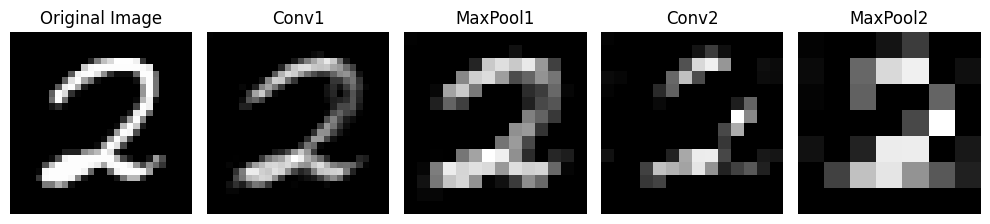

In [56]:
show_filters(model)

In [57]:
gc.collect()

62136

## Problem 7

----------------------------------------------------------
After epoch 50 | valid err rate:  2.15% | doing  61 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 40)

--------------------------------------------
Test error rate: 1.720%, training took 236s.
--------------------------------------------


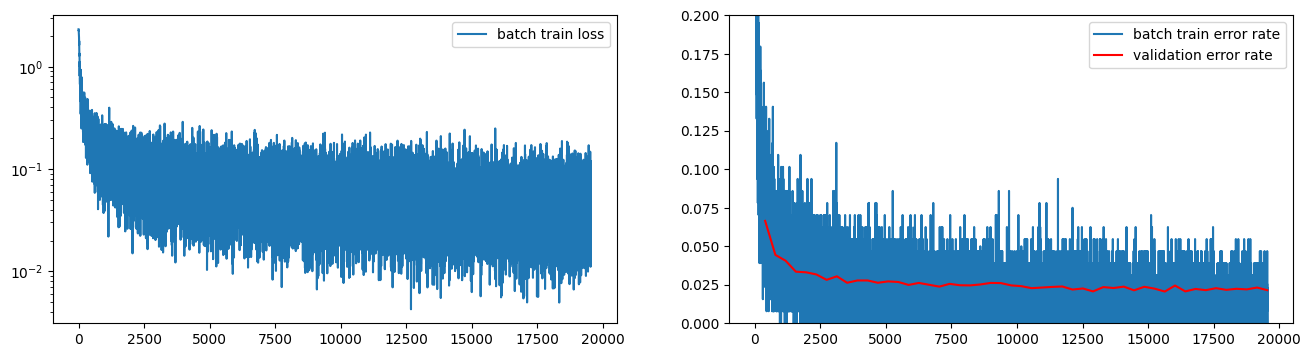

In [27]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(28 * 28, 1000),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1000, 200),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(200, 50),
            nn.ReLU(),
        )
        self.out = nn.Linear(50, 10)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model()

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Linear):
            n = p.weight.size(1)
            std = torch.sqrt(torch.tensor(2.0 / n))
            nn.init.normal_(p.weight, mean=0, std=std)
            if p.bias is not None:
                nn.init.zeros_(p.bias)

t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=30, max_num_epochs=50, device="cpu")

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


----------------------------------------------------------
After epoch 29 | valid err rate:  1.78% | doing  29 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 19)

--------------------------------------------
Test error rate: 1.240%, training took 142s.
--------------------------------------------


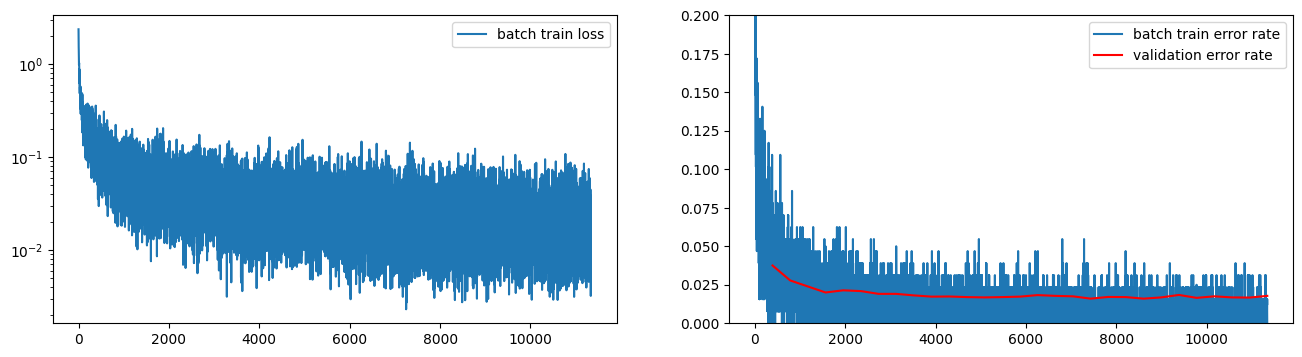

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(28 * 28, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1000, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(200, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
        )
        self.out = nn.Linear(50, 10)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model()

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Linear):
            n = p.weight.size(1)
            std = torch.sqrt(torch.tensor(2.0 / n))
            nn.init.normal_(p.weight, mean=0, std=std)
            if p.bias is not None:
                nn.init.zeros_(p.bias)

t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=15, max_num_epochs=30, device="cpu")

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


----------------------------------------------------------
After epoch 19 | valid err rate:  1.56% | doing  19 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 12)

--------------------------------------------
Test error rate: 1.010%, training took 995s.
--------------------------------------------


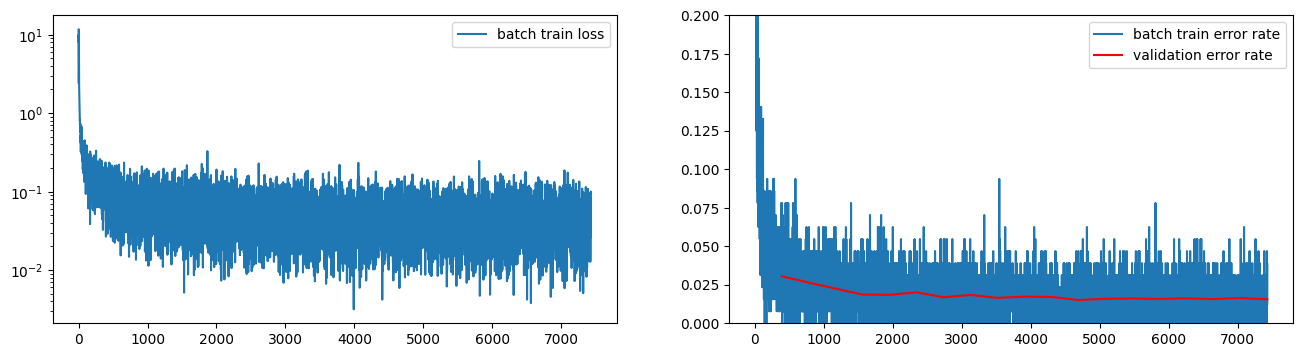

In [7]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        output = self.out(X)
        gc.collect()
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = ConvModel()

with torch.no_grad():
    for name, p in model.named_parameters():
        if isinstance(p, nn.Linear) or isinstance(p, nn.Conv2d):
            n = p.weight.size(1)
            std = torch.sqrt(torch.tensor(2.0 / n))
            nn.init.normal_(p.weight, mean=0, std=std)
            if p.bias is not None:
                nn.init.zeros_(p.bias)

t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=15, max_num_epochs=30, device="cpu")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

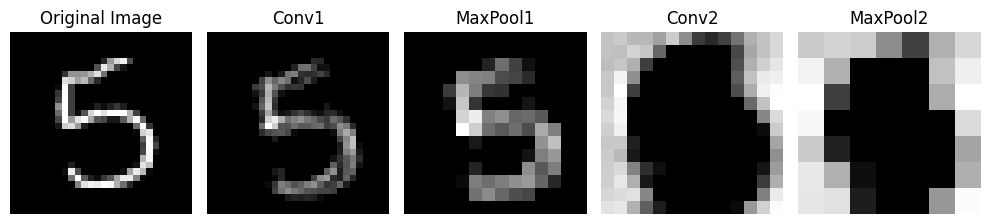

In [20]:
show_filters(model)

In [31]:
gc.collect()

14747